<img src="https://lh3.googleusercontent.com/proxy/4l48OT94uOsOD6Lz9ARLN7cT4fjpdq4Zt6dBNiY9HEqt5GqNlxNfNVMY64OHxdODn3Nhtcxx7zWMC6wCaigTwWxTKfbAmW9MP7tl-aHO" title="Department of Informatics and Telecommunications - University of Athens"/>

---
# Data Mining - 2nd Project - Spring Semester 2020
> # WordClouds  -  Classification  -  Clustering 
---
## Team members : 
> ##  - Nikoletos Konstantinos | sdi1700104
> ##  - Iglezou Myrto          | sdi1700038

______

Import of essential **__libraries__**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys # only needed to determine Python version number
import matplotlib # only needed to determine Matplotlib version number
import wordcloud as wc
import collections
import seaborn as sbn
import nltk
import os
import collections
import itertools  
from wordcloud import STOPWORDS,WordCloud
from pandas import DataFrame, read_csv
from nltk import word_tokenize, BigramCollocationFinder
from nltk.corpus import stopwords as stopwords2
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from sklearn import svm,metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB,CategoricalNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from IPython.display import HTML
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

------
Reading __articles__ from given directory and forming a __dataframe__

In [3]:
# directoryPath = r"C:\Users\nikol\Desktop\fulltext\data\\"
directoryPath = r"C:\Users\myrto\Desktop\data\\"
categories = os.listdir(directoryPath)
categories.remove('README.TXT')

df = pd.DataFrame(columns=['id','title','content','category'])

id=0
for category in categories:       # create the dataframe 
    path = directoryPath + category
    txtfiles = os.listdir(path)
    for txt in txtfiles:    
        filepath = path + "\\" + txt
        file = open(filepath,"r")
        filecontent = file.readlines()
        title = filecontent[0].replace("\n","")
        del filecontent[0]
        content = "".join(filecontent)
        df.loc[id] = [id,title,content,str(category)]
        id+=1

Creation of __stopwords__ set, consisted of:
<ol>
 <li>GitHub file</li>
 <li>Nltk library</li>
 <li>wordcloud library</li>
</ol>

In [4]:
punctuation = list(punctuation)
punctuation.append('’')
# stopwordsPath = r"C:\Users\nikol\Desktop\Project-2-DataMining-\\english_stopwords.txt"
stopwordsPath = r"C:\Users\myrto\Documents\GitHub\Project-2-DataMining-\english_stopwords.txt"
file = open(stopwordsPath,"r",errors='ignore')
stopwords_fromHub = [x.replace('\n',"") for x in file.readlines()]
stopwords = set(STOPWORDS)
stopwords_nltk =  set(stopwords2.words('english'))
stopwords.update(stopwords_nltk)
stopwords.update(set(stopwords_fromHub))

---
# 1. WordClouds
---


Function that creates a __wordcloud__

In [4]:
def generate_WordCloud(data,stopwords):
    textWords = []
    for x in data:
        for y in word_tokenize(x) :
            y = y.lower()
            y = WordNetLemmatizer().lemmatize(y)
            if (y not in stopwords) and (y not in punctuation) and y.isalpha():
                textWords.append(y)
                
    counter = collections.Counter(textWords)
    words = WordCloud(background_color='black',stopwords=stopwords,margin=0).generate_from_frequencies(frequencies=dict(counter))

    plt.figure(figsize=(20,10))
    plt.imshow(words,interpolation='bilinear')
    plt.axis("off")
    plt.show()

# $\bullet$ Business WordCloud

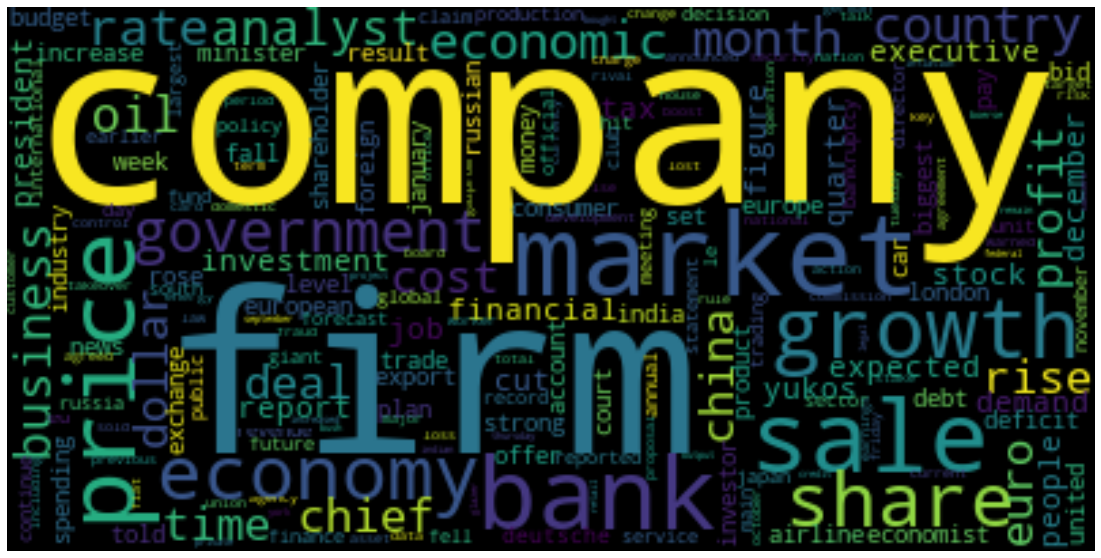

In [8]:
temp = df.loc[df['category'] == 'business']
generate_WordCloud(temp['content'],stopwords)

#  $\bullet$ Entertainment WordCloud

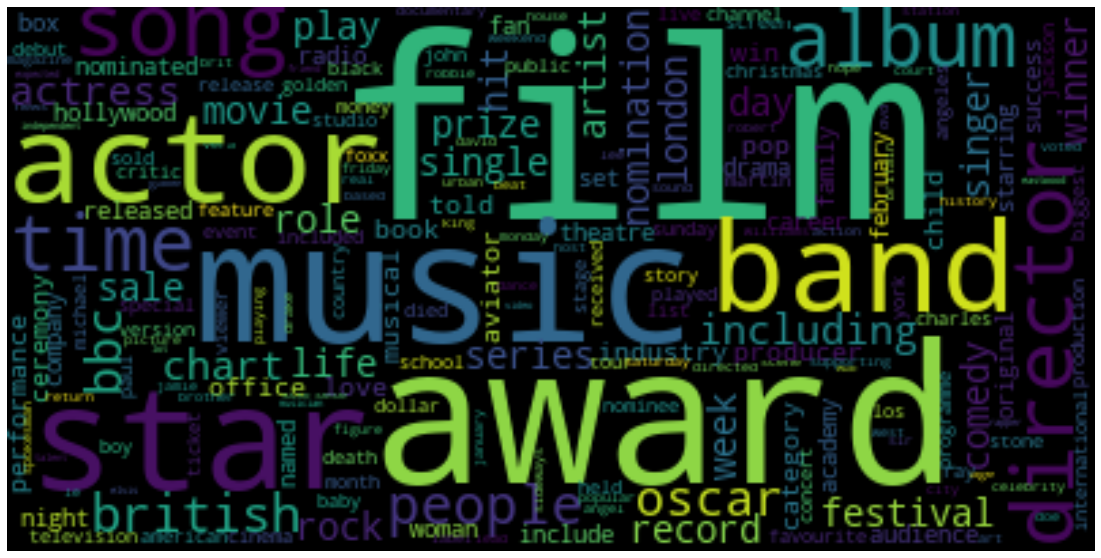

In [9]:
temp = df.loc[df['category'] == 'entertainment']
generate_WordCloud(temp['content'],stopwords)

# $\bullet$ Politics WordCloud

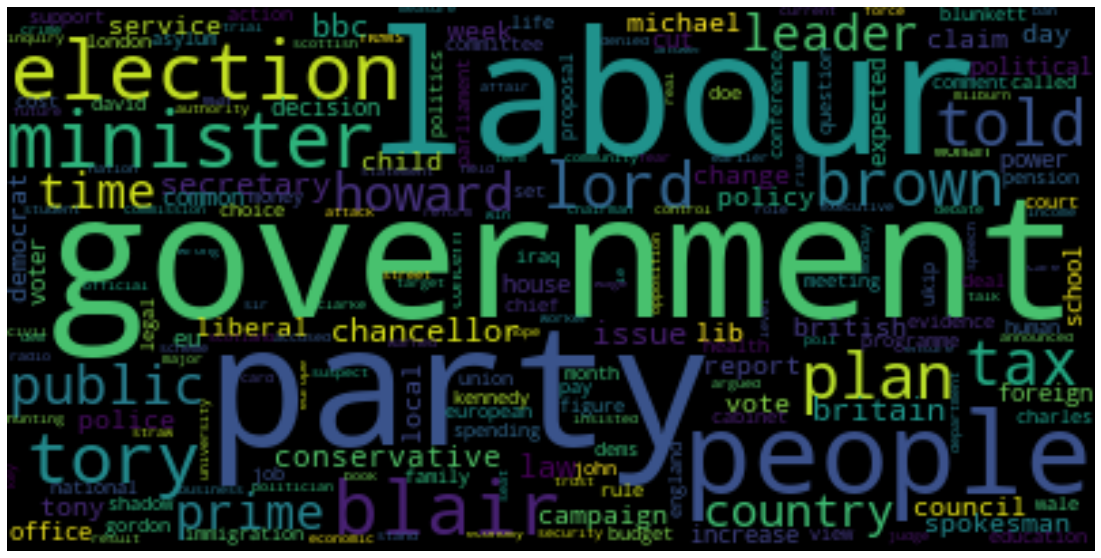

In [10]:
temp = df.loc[df['category'] == 'politics']
generate_WordCloud(temp['content'],stopwords)

# $\bullet$ Sport WordCloud

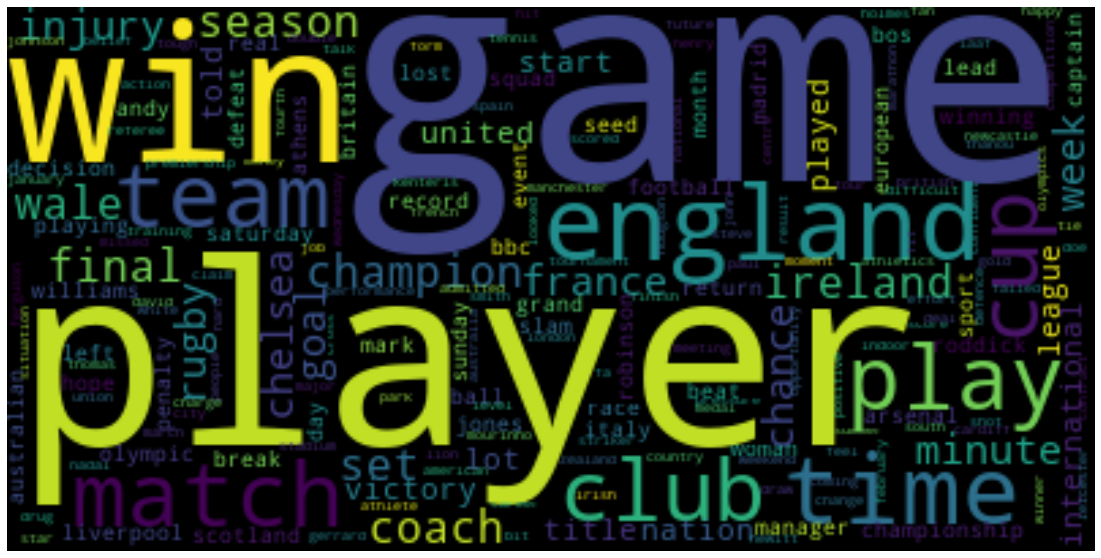

In [11]:
temp = df.loc[df['category'] == 'sport']
generate_WordCloud(temp['content'],stopwords)

# $\bullet$ Tech WordCloud

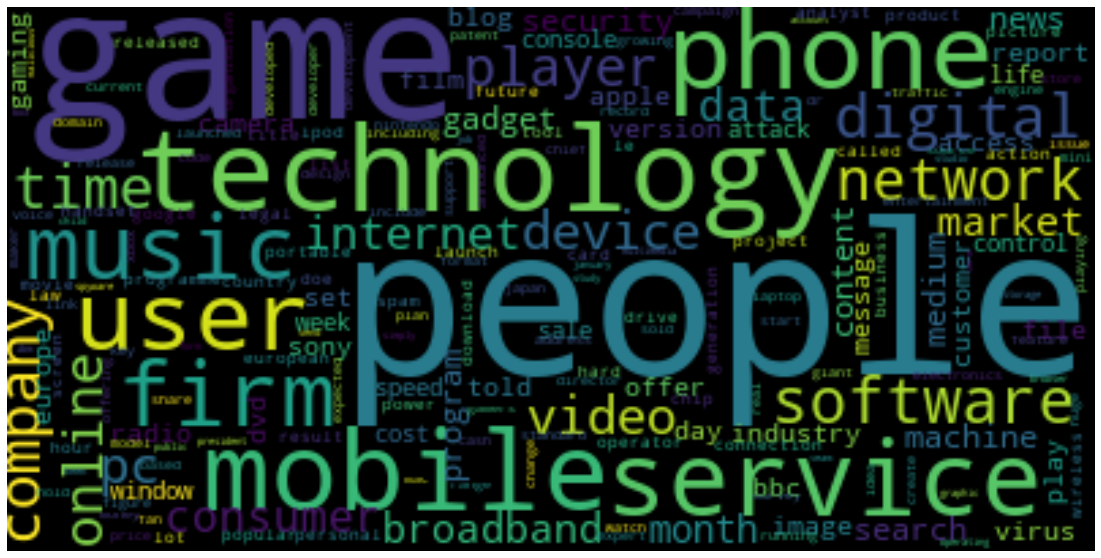

In [12]:
temp = df.loc[df['category'] == 'tech']
generate_WordCloud(temp['content'],stopwords)



---

#        2. Classification 


---



Method that vectorizes X_train,X_test

In [5]:
def vectorizeData(X_train,X_test,vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train,X_test

__estimator :__ Calls the wanted classification for its model

In [6]:
def estimator(estimator,parameter_grid,X_train,X_test,y_train,y_test,folds):
    if parameter_grid: # if parameters are given
        grid = GridSearchCV(estimator,parameter_grid,cv=folds,refit=False,return_train_score=False,scoring=['accuracy','precision_macro','recall_macro','f1_macro'])
        grid.fit(X_train, y_train)  # fitting the model for grid search 
        tempDf = pd.DataFrame(grid.cv_results_)
    else:
        cv_results = cross_validate(estimator,X_train,y_train,cv = folds,scoring = ['accuracy','precision_macro','recall_macro','f1_macro'])
        tDf = pd.DataFrame(cv_results)
        cols = ['test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro']
        tempdict = {}
        for c in cols:    # find the mean of every column
            tempdict[c] = [tDf[c].mean(axis=0)]
        tempDf = pd.DataFrame(data=tempdict)
    return tempDf

__highlight_max(s)__ : highlights the cell of a dataframe that has the maximum value of the column

In [8]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

__create_plots:__ produces two roc-subplot(count,tf-idf)

In [9]:
def create_plots(estimator,y_test,t_test,b_test,folds,modelName):
    clf = OneVsRestClassifier(estimator)
    tfidf_predictions = cross_val_predict(estimator,t_test,y_test,cv=folds,method='predict')
    count_predictions = cross_val_predict(estimator,b_test,y_test,cv=folds,method='predict')
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))
    fig.suptitle(modelName,fontsize=25,fontweight='bold')
    create_ROCplot(5,tfidf_predictions,y_test,ax1,'Tf-idf Vectorizer')    
    create_ROCplot(5,count_predictions,y_test,ax2,'Count Vectorizer')  

---
ROC-plot function , it produses a roc-plot for given __predictions and y_test__

In [10]:
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from numpy import interp
from itertools import cycle

def create_ROCplot(n_classes,predictions,y_test,ax,title):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2

    ax.plot(fpr["macro"],tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','darkred'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color,lw=lw,label='Class - {0} - (area = {1:0.2f})'''.format(classes[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.annotate('Random Guess',(.5,.48),color='red')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax.legend(loc="lower right")

---

In [11]:
def make_Classification(model,parameters,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,wantedColumns,nameDict):

    tfidf_df = estimator(model,parameters,tfidf_train,tfidf_test, y_train, y_test,folds)
    count_df = estimator(model,parameters,count_train,count_test, y_train, y_test,folds)
    tfidf_df.insert(0,'Vectorizer','Tf-idf')
    count_df.insert(0,'Vectorizer','Count')
    tfidf_df  = pd.DataFrame(tfidf_df,columns=wantedColumns)
    count_df  = pd.DataFrame(count_df,columns=wantedColumns)
    model_df = pd.concat([tfidf_df,count_df],ignore_index=True)
    model_df.rename(columns=nameDict,inplace=True)
    return model_df

Function for __statistics__

In [17]:
def classificationStatistics(df):
    wantedColumns = ['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']
    dictionary = {}
    for col in wantedColumns:
        dictionary[col] = [df[col].min(),df[col].max(),df[col].mean()]
    statdf = pd.DataFrame(dictionary,columns=wantedColumns)
    statdf.insert(0,'Statistics',['Minimun','Maximum','Average'])
    return statdf

__Plot__ for the statistics of the classification

In [21]:
def statsisticsPlot(df):
    metricsColumns = ['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']
    columns = [x for x in df.columns.tolist() if x not in metricsColumns]
    df.plot(kind = 'bar',x=columns,y='Accuracy')    
statsisticsPlot(statdf)
    
        
    

ValueError: x must be a label or position

Creation of test/train data sets and process of those sets  

In [13]:
y = df['category']
X = df['content']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y) # split data

le = preprocessing.LabelEncoder() 
le.fit(y_train)    # change string to number for categories

y_train = le.transform(y_train)
y_test = le.transform(y_test)

tfidfVectorizer = TfidfVectorizer(max_df=1.0,min_df=1)
tfidf_train,tfidf_test = vectorizeData(X_train,X_test,tfidfVectorizer)

countVectorizer = CountVectorizer()
count_train,count_test = vectorizeData(X_train,X_test,countVectorizer)

folds = StratifiedKFold(n_splits=10)
classes = le.classes_

---


# $\bullet$ Support Vector Machines

> A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

__Parameters:__

 * __Kernel__ In practice, SVM algorithm is implemented with kernel that transforms an input data space into the required form. SVM uses a technique called the kernel trick in which kernel takes a low dimensional input space and transforms it into a higher dimensional space. In simple words, kernel converts non-separable problems into separable problems by adding more dimensions to it. It makes SVM more powerful, flexible and accurate. The following are some of the types of kernels used by SVM.
   * __Linear :__ the equation for prediction for a new input using the dot product between the input (x) and each support vector (xi) is calculated as follows:  ___f(x) = B(0) + sum(ai * (x,xi))___
   * __Radial Basis Function (RBF) Kernel__
RBF kernel, mostly used in SVM classification, maps input space in indefinite dimensional space. Following formula explains it mathematically     __K(x,xi)=exp(−gamma∗sum(x−xi^2))__

 * __gamma__ : The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. In other words, with low gamma, points far away from plausible seperation line are considered in calculation for the seperation line. Where as high gamma means the points close to plausible line are considered in calculation.
 
<figure class="half" style="display:flex">
    <img style="width:450px" src="https://miro.medium.com/max/1200/1*ClmsnU_yb1YtIwAAr7krmg.png">
    <img style="width:450px" src="https://miro.medium.com/max/1200/1*dGDQxV8j83VB90skHsXktw.png">
</figure>


* __Regularization or C__ 
The Regularization parameter (often termed as C parameter in python’s sklearn library) tells the SVM optimization how much you want to avoid misclassifying each training example.
> For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points.

__Advantage of SVM classifiers :__
SVM classifiers offers great accuracy and work well with high dimensional space. SVM classifiers basically use a subset of training points hence in result uses very less memory.

__Disadvantage of SVM classifiers :__
They have high training time hence in practice not suitable for large datasets. Another disadvantage is that SVM classifiers do not work well with overlapping classes.

In [15]:
SVM_param = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf','linear']
}

svmDf = make_Classification(
    svm.SVC(),
    SVM_param,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','param_C', 'param_gamma', 'param_kernel','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_C': 'C', 'param_gamma' : 'gamma', 'param_kernel':'Kernel','mean_test_accuracy':'Accuracy','mean_test_precision_macro':'Precision (macro)',
                'mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'}
)
svmDf.style.format("{:.2f}",subset=['C','gamma']).format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

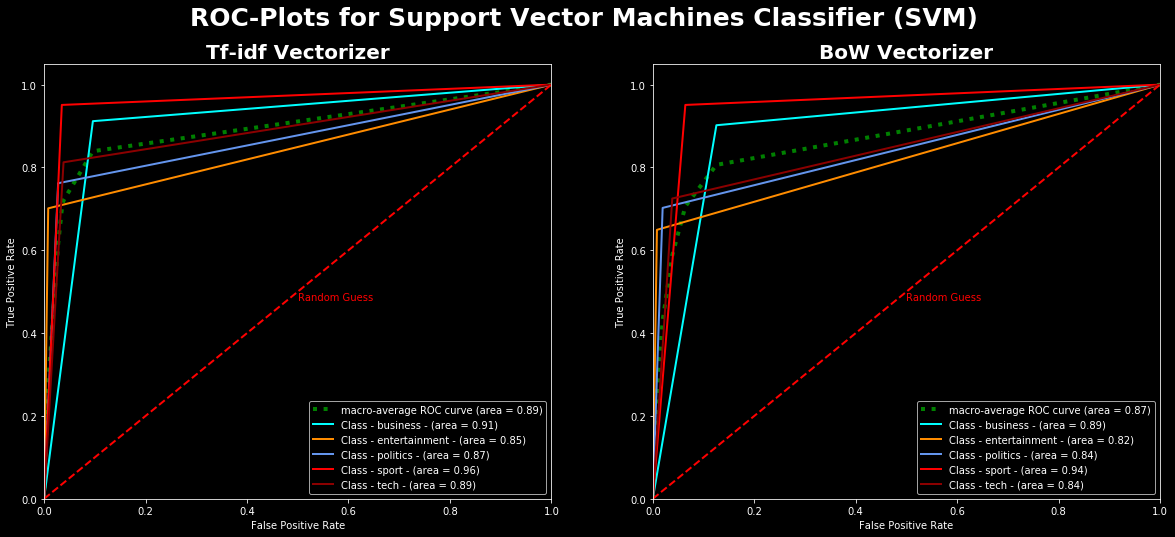

In [30]:
create_plots(svm.SVC(),y_test,tfidf_test,count_test,folds,'ROC-Plots for Support Vector Machines Classifier (SVM)')

---
# $\bullet$ RandomForestClassifier

> Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

__Parameters:__
 * __n_estimators :__ Number of trees in forest. Default is 10.
 * __criterion:__ “gini” or “entropy” same as decision tree classifier.

__Advantages of Random Forest algorithm__
 * It overcomes the problem of overfitting by averaging or combining the results of different decision trees.
 * Random forests work well for a large range of data items than a single decision tree does.
 * Random forest has less variance then single decision tree.
 * Random forests are very flexible and possess very high accuracy.
 * Scaling of data does not require in random forest algorithm. It maintains good accuracy even after providing data without scaling.
 * Random Forest algorithms maintains good accuracy even a large proportion of the data is missing.

__Disadvantages of Random Forest algorithm__

 * Complexity is the main disadvantage of Random forest algorithms.
 * Construction of Random forests are much harder and time-consuming than decision trees.
 * More computational resources are required to implement Random Forest algorithm.
 * It is less intuitive in case when we have a large collection of decision trees.
 * The prediction process using random forests is very time-consuming in comparison with other algorithms.

In [14]:
randomForest_parameters = {
    'n_estimators' : [1,10,50,100],
    'criterion'    : ['gini','entropy']
}

rfcdf = make_Classification(
    RandomForestClassifier(),
    randomForest_parameters,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','param_n_estimators', 'param_criterion','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_n_estimators': 'n_estimators', 'param_criterion' : 'Criterion', 'mean_test_accuracy':'Accuracy',
                'mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'}
)
rfcdf.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

In [16]:
statdf = classificationStatistics(rfcdf)
statdf.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

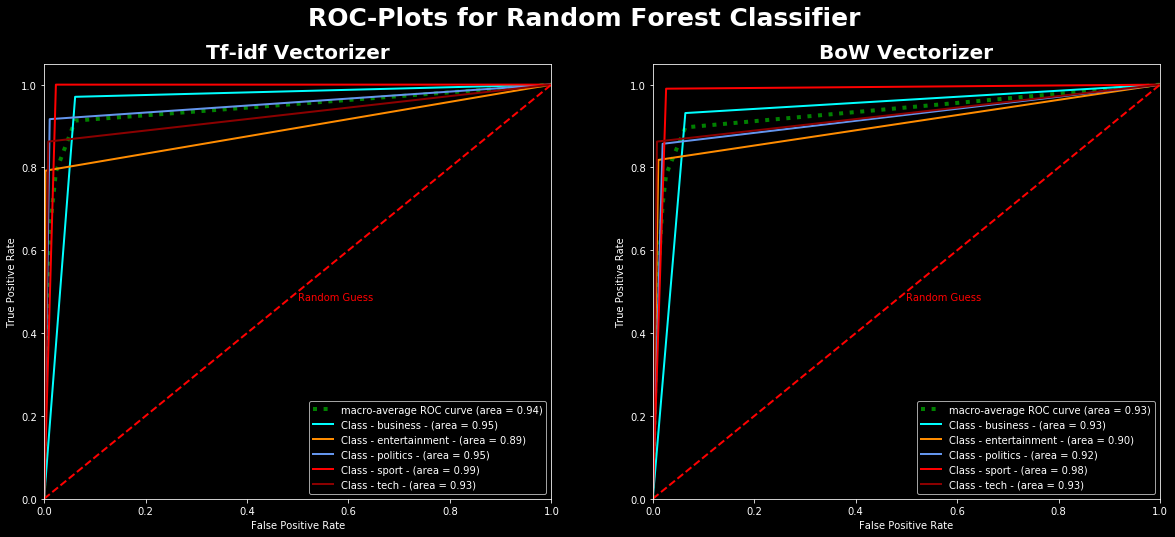

In [14]:
create_plots(RandomForestClassifier(),y_test,tfidf_test,count_test,folds,'ROC-Plots for Random Forest Classifier')

---

# $\bullet$ Naive Bayes


 Data processing for __*Naive Bayes*__ algorithms

In [13]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()
count_train = count_train.toarray()
count_test = count_test.toarray()

# - Gaussian
In Gaussian Naive Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution. A Gaussian distribution is also called Normal distribution. When plotted, it gives a bell shaped curve which is symmetric about the mean of the feature values as shown below:
<img src="https://media.geeksforgeeks.org/wp-content/uploads/naive-bayes-classification-1.png" title="The normal distribution"/>

The likelihood of the features is assumed to be Gaussian, hence, conditional probability is given by:
<img src="https://www.geeksforgeeks.org/wp-content/ql-cache/quicklatex.com-7fb78d7323fcbade0cb664161a8e84c4_l3.svg" width="400" height="400" title="Probability"/>


In [14]:
emptydict = {}

nb = make_Classification(
    GaussianNB(),
    emptydict,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'}
)
nb.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

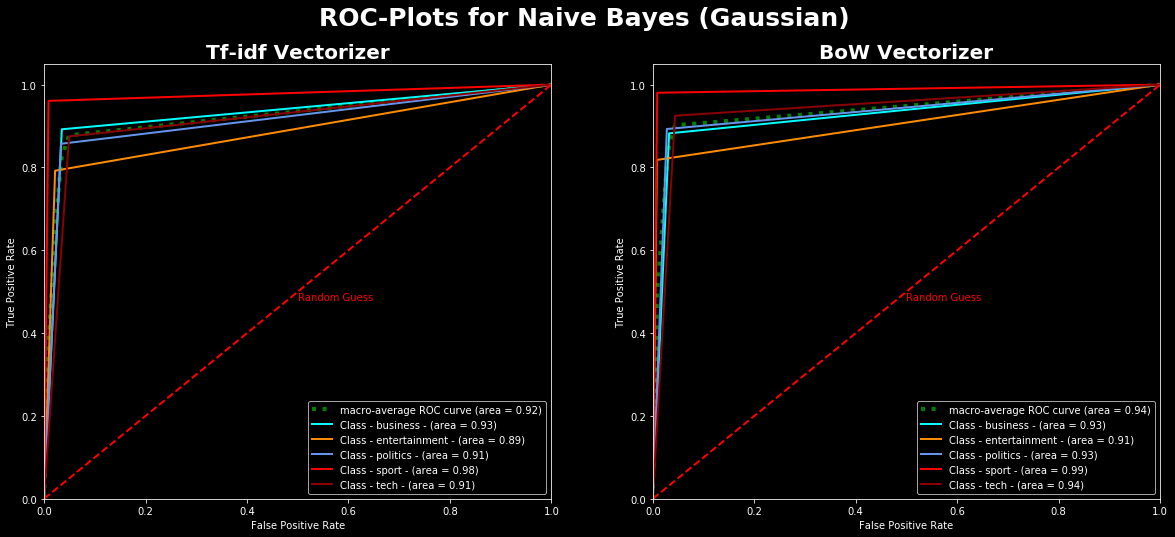

In [15]:
create_plots(GaussianNB(),y_test,tfidf_test,count_test,folds,'ROC-Plots for Naive Bayes (Gaussian)')

---
# - Comparison between different Naive Bayes algorithms : *Gaussian,Bernoulli,Complement and Multinomial*  

$\bullet$ __Multinomial:__ It is used for discrete counts. This is mostly used for document classification problem, i.e whether a document belongs to the category of sports, politics, technology etc. The features/predictors used by the classifier are the frequency of the words present in the document.

$\bullet$ __Bernoulli:__ This is similar to the multinomial naive bayes but the predictors are boolean variables. The parameters that we use to predict the class variable take up only values yes or no, for example if a word occurs in the text or not.

$\bullet$ __Complement:__ Another useful naïve Bayes model which was designed to correct the severe assumptions made by Multinomial Bayes classifier. This kind of NB classifier is suitable for imbalanced data sets. The Scikit-learn provides sklearn.naive_bayes.ComplementNB to implement the Gaussian Naïve Bayes algorithm for classification.



In [16]:
emptydict = {}
gaussianNB = make_Classification(
    GaussianNB(),
    emptydict,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
gaussianNB.insert(0,'Naive Bayes Algorithm','GaussianNB')

bernoulliNB = make_Classification(
    BernoulliNB(),
    emptydict,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
bernoulliNB.insert(0,'Naive Bayes Algorithm','BernoulliNB')

multinomialNB = make_Classification(
    MultinomialNB(),
    emptydict,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
multinomialNB.insert(0,'Naive Bayes Algorithm','MultinomialNB')

complementNB = make_Classification(
    ComplementNB(),
    emptydict,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
complementNB.insert(0,'Naive Bayes Algorithm','ComplementNB')

nb_comparison = pd.concat([bernoulliNB,multinomialNB,gaussianNB,complementNB],ignore_index=True)

In [17]:
nb_comparison.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

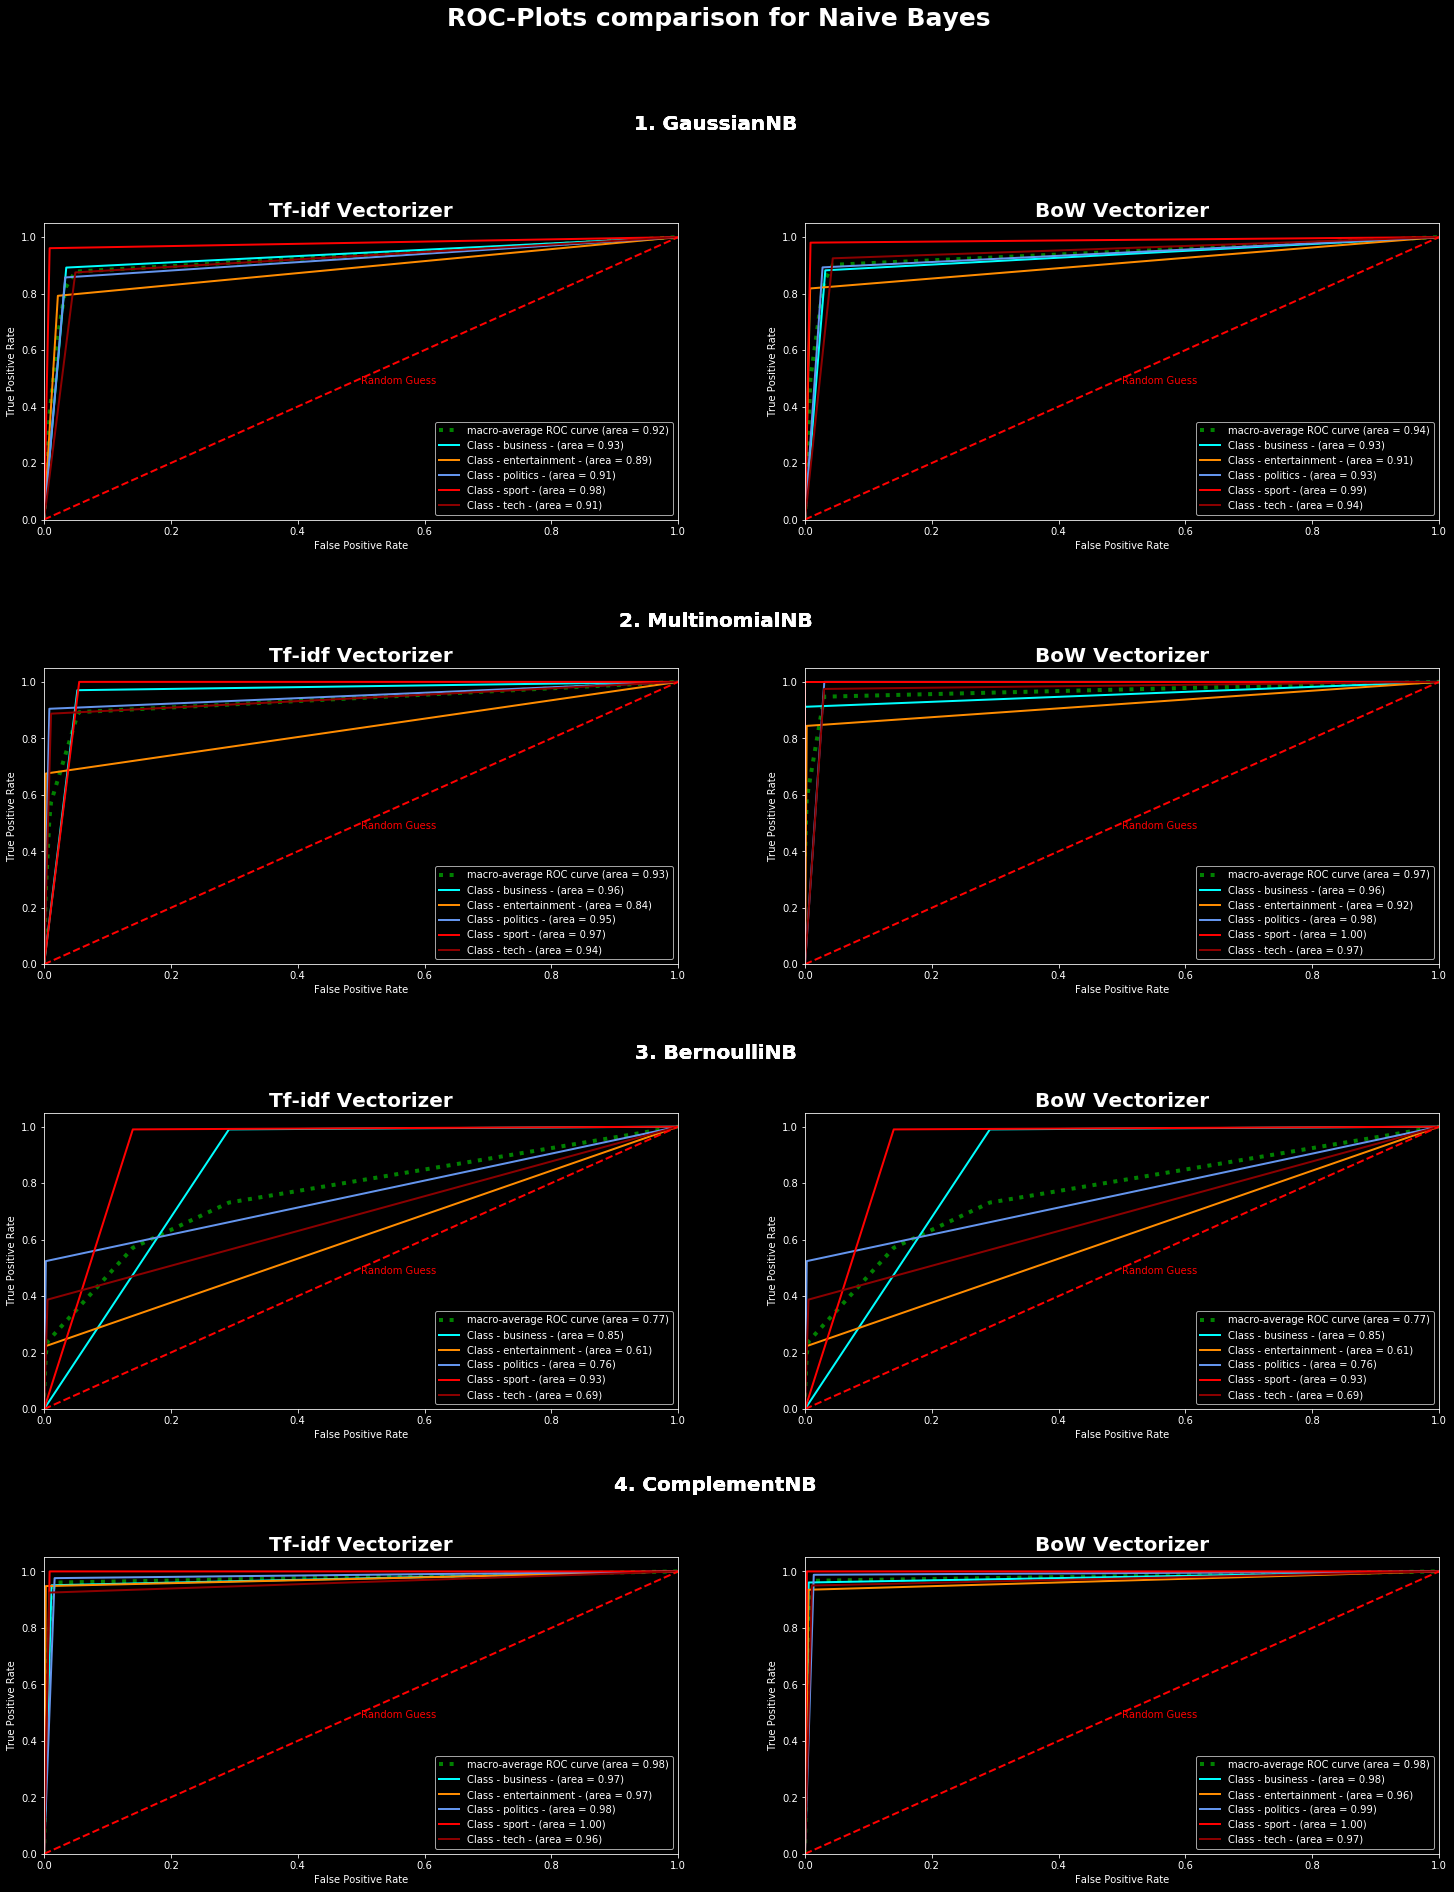

In [18]:
def naiveBayes_plots(estimators,y_test,t_test,b_test,folds,modelName):
    plt.style.use('dark_background')
    fig, axs = plt.subplots(4,2,figsize=(25,30))
    fig.subplots_adjust(hspace = 0.4)
    fig.suptitle(modelName,fontsize=25,fontweight='bold')
    i=0;j=0;
    for estimator in estimators:
        clf = OneVsRestClassifier(estimator)
        tfidf_predictions = cross_val_predict(estimator,t_test,y_test,cv=folds,method='predict')
        count_predictions = cross_val_predict(estimator,b_test,y_test,cv=folds,method='predict')
        plt.figtext(0.5,0.93, "1. GaussianNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.figtext(0.5,0.7, "2. MultinomialNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.figtext(0.5,0.5, "3. BernoulliNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.figtext(0.5,0.3, "4. ComplementNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.subplots_adjust(hspace = 0.5)
        create_ROCplot(5,tfidf_predictions,y_test,axs[i,j],'Tf-idf Vectorizer')    
        create_ROCplot(5,count_predictions,y_test,axs[i,j+1],'Count Vectorizer')
        j=0;i+=1;

estimators = [GaussianNB(),MultinomialNB(),BernoulliNB(),ComplementNB()]
naiveBayes_plots(estimators,y_test,tfidf_test,count_test,folds,'ROC-Plots comparison for Naive Bayes')

---
# $\bullet$ K-Nearest Neighbour

> KNN is a non-parametric and lazy learning algorithm. Non-parametric means there is no assumption for underlying data distribution. In other words, the model structure determined from the dataset. This will be very helpful in practice where most of the real world datasets do not follow mathematical theoretical assumptions. Lazy algorithm means it does not need any training data points for model generation. All training data used in the testing phase. This makes training faster and testing phase slower and costlier. Costly testing phase means time and memory. In the worst case, KNN needs more time to scan all data points and scanning all data points will require more memory for storing training data.

__Parameters:__
  * __k :__ the number of nearest neighbor, order to classify the a data point
 
__Characteristcs__:
  * __Cosine Similarity:__ The distance method in this edition
  * __Majority Voting :__ From the 'k' nearest neighbours, the classs is decided from the most common class between k elements 
  
__Advantages:__
  * Very simple algorithm to understand and interpret.
  * Very useful for nonlinear data because there is no assumption about data in this algorithm.
  * It is a versatile algorithm as we can use it for classification as well as regression.
  * It has relatively high accuracy but there are much better supervised learning models than KNN.

__Disadvantages:__
  * It is computationally a bit expensive algorithm because it stores all the training data.
  * High memory storage required as compared to other supervised learning algorithms.
  * Prediction is slow in case of big N.
  * It is very sensitive to the scale of data as well as irrelevant features.



In [19]:
class KNN:
    def __init__(self,k):
        self.k = k
    
    def fit(self,X,y):
        self.vectorized_X = X
        self._y_train = y
        
    def majorityVoting(self,neighbours):
        frequency = collections.Counter(t[1] for t in neighbours)
        return frequency.most_common(1)[0][0]    
    
    def get_neighbours(self,index_Y,topN,category_list,similarity_matrix):
        
        similarity_dictionary = {}
        for index_X in range(0,len(similarity_matrix[index_Y])):  # finding the most similar to the wanted id
            XYtuple = (index_X,category_list[index_X])
            similarity_dictionary[XYtuple] = similarity_matrix[index_Y][index_X]

        sortedDict = {k : similarity_dictionary[k] for k in sorted(similarity_dictionary,key = similarity_dictionary.get,reverse=True)}
        if topN>len(similarity_matrix[index_Y]): # checking if topN is greater that the size of list
            topN=len(similarity_matrix[index_Y])
        out = dict(itertools.islice(sortedDict.items(),topN))
        neighbours = []
        for k,v in out.items():
            neighbours.append(k)

        return neighbours

    def predict(self,X):
        
        similarity_matrix = cosine_similarity(X,self.vectorized_X)
        category_list = self._y_train.tolist()
        predictions = []

        for i in range(similarity_matrix.shape[0]):
            neighbours = self.get_neighbours(i,self.k,category_list,similarity_matrix)
            category = self.majorityVoting(neighbours)
            predictions.append(category)
        
        return predictions

    def get_params(self,deep):
        params = {'k':self.k}
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if(key=='k'):
                self.k = value
        return self

    def score(self,X,y,sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [20]:
knn_parameters = {
    'k' : [1,5,10,20,50,100]
}

knn = make_Classification(
    KNN(5),
    knn_parameters,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','param_k','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_k': 'Number of neighbours','mean_test_accuracy':'Accuracy','mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'},
)
knn.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

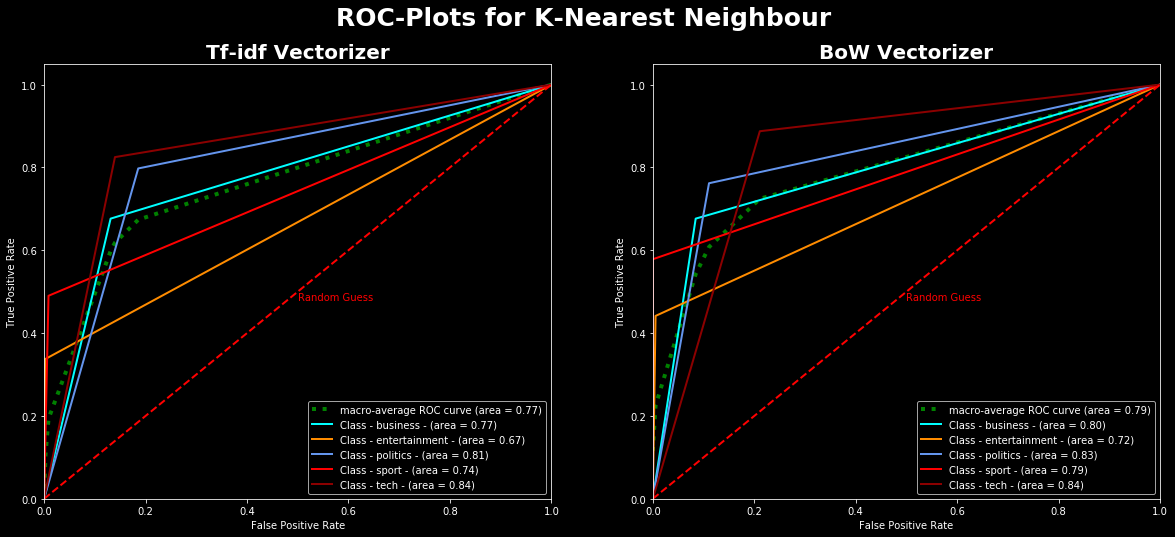

In [29]:
create_plots(KNN(50),y_test,tfidf_test,count_test,folds,'ROC-Plots for K-Nearest Neighbour')

---
# 3. Beat the Benchmark - RandomForestClassifier
---
Text cleaning steps:
1. Removal of __tags__
2. Removal of __puncutation__
3. Removal of __numerics__
4. Removal of __stopwords__
5. Removal of very __short words__
6. Stemming / __Lemmatizing__


In [19]:
import unicodedata

def normalize_word(word):
    # Will remove the encode token by token
    word = str(word)
    word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def textProcessor(inputData):
    processed_data = []   
    for text in inputData.values:
        textWords = []
        for word in word_tokenize(text):
            word = normalize_word(word)
            word = word.lower()
            word = WordNetLemmatizer().lemmatize(word)
            word.replace('\n','')
            word.replace('<html>','')
            word.replace('<p>','')
            word.replace("'s",'')
            if word.isnumeric():
                word = '#num#'
            if (word not in stopwords) and (word not in punctuation) and (word != "'s"):
                textWords.append(word)
        processed_data.append(' '.join(textWords))
    inputData.update(pd.Series(processed_data,index=inputData.index))

In [23]:
# Vectorizing processed data
textProcessor(X_train)
tfidfVectorizer = TfidfVectorizer(max_df=1.0,min_df=1)
tfidf_train,tfidf_test = vectorizeData(X_train,X_test,tfidfVectorizer)

countVectorizer = CountVectorizer()
count_train,count_test = vectorizeData(X_train,X_test,countVectorizer)

In [24]:
randomForest_parameters = {
    'n_estimators' : [1,10,50,100],
    'criterion'    : ['gini','entropy']
}

rfcdf = make_Classification(
    RandomForestClassifier(),
    randomForest_parameters,tfidf_train,tfidf_test,count_train,count_test,y_train,y_test,folds,
    wantedColumns = ['Vectorizer','param_n_estimators', 'param_criterion','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_n_estimators': 'n_estimators', 'param_criterion' : 'Criterion', 'mean_test_accuracy':'Accuracy',
                'mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'}
)
rfcdf.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

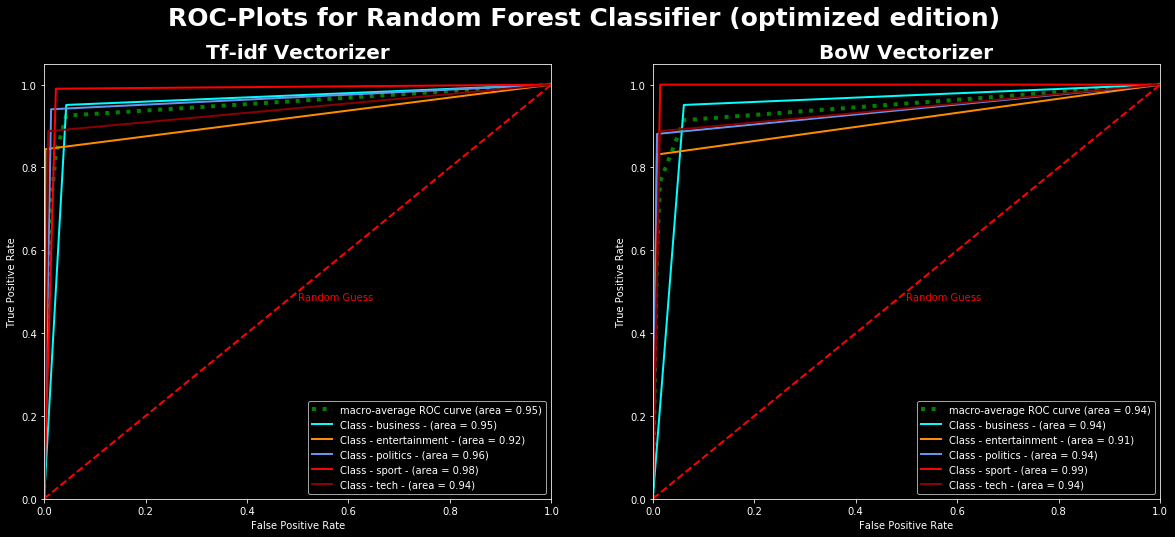

In [25]:
create_plots(RandomForestClassifier(),y_test,tfidf_test,count_test,folds,'ROC-Plots for Random Forest Classifier (optimized edition)')

---
# 4. Clustering
---

Modify the content of the articles for word2vec

In [22]:
contentlist = X_train.values
sentences = []
for x in contentlist:
    textWords = []
    for y in word_tokenize(x):
        y = y.lower()
        y = WordNetLemmatizer().lemmatize(y)
        y.replace('\n','')
        if y not in punctuation:
            textWords.append(y)
    sentences.append(textWords)


Function to create the plot after the clustering

In [23]:
 def K_Means_plot(components,real_data,title,labels):
    plt.style.use('dark_background')

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
  
    ax1.scatter(components[0], components[1],c=labels, s=50, cmap='plasma')
    ax1.set_xlabel('Similarity-X')
    ax1.set_ylabel('Similarity-Y')
    ax1.set_title(title,fontsize=20,fontweight='bold')
    ax1.grid(True)

    noCluster_plot(components,real_data,ax2,'Real Data') 


Function to create the plot of the original data

In [24]:
def noCluster_plot(components,data,ax,title):    # plot for the real data
    sc = ax.scatter(components[0], components[1],c=data, s=50, cmap='Spectral')
    ax.set_xlabel('Similarity-X')
    ax.set_ylabel('Similarity-Y')
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax.legend(sc.legend_elements()[0],classes)
    ax.grid(True)

Function to fit and find the components for every compression method

In [25]:
def compositionModel(model,data):
    model.fit(data)
    composed_data = model.fit_transform(data)
    model_components = pd.DataFrame(composed_data)
    return model_components

---
Function for the __K-Means__ clustering
>K-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. K-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, Better Euclidean solutions can be found using k-medians and k-medoids.

In [26]:
def K_MeansClustering(data):
    normalized_data = preprocessing.normalize(data)
    km = KMeans(n_clusters=5)
    labels = km.fit_predict(normalized_data) # Fit model to samples
    return labels

In [27]:
from sklearn import preprocessing

def modelPlots(model,w2v_data,tfidf_data,count_data,real_data):
    labels = K_MeansClustering(tfidf_data)
    components = compositionModel(model,tfidf_data.todense())
    K_Means_plot(components,y_train,'Tfidf Data',labels)
    labels = K_MeansClustering(w2v_data)
    components = compositionModel(model,w2v_data)
    K_Means_plot(components,y_train,'Word2vec Data',labels)
    labels = K_MeansClustering(count_data)
    components = compositionModel(model,count_data)
    K_Means_plot(components,y_train,'Count Data',labels)


Find the average vector  for every article using the vectors of each word in it.

In [28]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        # if word in index2word_set:
        nwords = nwords+1
        featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


Create the pre-trained embeddings (word2vec)

In [29]:
from gensim.models import Word2Vec

vectorizedSent = []
word2vec_model = Word2Vec(sentences, min_count = 1, window = 5) 
for text in sentences:
    sentence = avg_sentence_vector(text, model=word2vec_model, num_features=100,index2word_set=set(word2vec_model.wv.vocab))
    vectorizedSent.append(sentence)

---
# Principal Component Analysis (PCA)

> Principal component analysis, or PCA, is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed. PCA is mostly used as a tool in exploratory data analysis and for making predictive models. It is often used to visualize genetic distance and relatedness between populations. PCA is either done in the following 2 steps:
* calculating the data covariance (or correlation) matrix of the original data
* performing eigenvalue decomposition on the covariance matrix

__Advantages of PCA:__

 * __Removes Correlated Features__: You cannot run your algorithm on all the features as it will reduce the performance of your algorithm and it will not be easy to visualize that many features in any kind of graph. So, you MUST reduce the number of features in your dataset. You need to find out the correlation among the features (correlated variables). Finding correlation manually in thousands of features is nearly impossible, frustrating and time-consuming. PCA does this for you efficiently.

 * __Improves Algorithm Performance__: PCA is a very common way to speed up your Machine Learning algorithm by getting rid of correlated variables which don't contribute in any decision making. The training time of the algorithms reduces significantly with less number of features. So, if the input dimensions are too high, then using PCA to speed up the algorithm is a reasonable choice. 

 * __Reduces Overfitting__: Overfitting mainly occurs when there are too many variables in the dataset. So, PCA helps in overcoming the overfitting issue by reducing the number of features.

 * __Improves Visualization__: It is very hard to visualize and understand the data in high dimensions. PCA transforms a high dimensional data to low dimensional data (2 dimension) so that it can be visualized easily. 

__Disadvantages of PCA:__

 * __Independent variables become less interpretable__: After implementing PCA on the dataset, your original features will turn into Principal Components. Principal Components are the linear combination of your original features. Principal Components are not as readable and interpretable as original features.

 * __Data standardization is must before PCA__: You must standardize your data before implementing PCA, otherwise PCA will not be able to find the optimal Principal Components. 

 * __Information Loss__: Although Principal Components try to cover maximum variance among the features in a dataset, if we don't select the number of Principal Components with care, it may miss some information as compared to the original list of features.

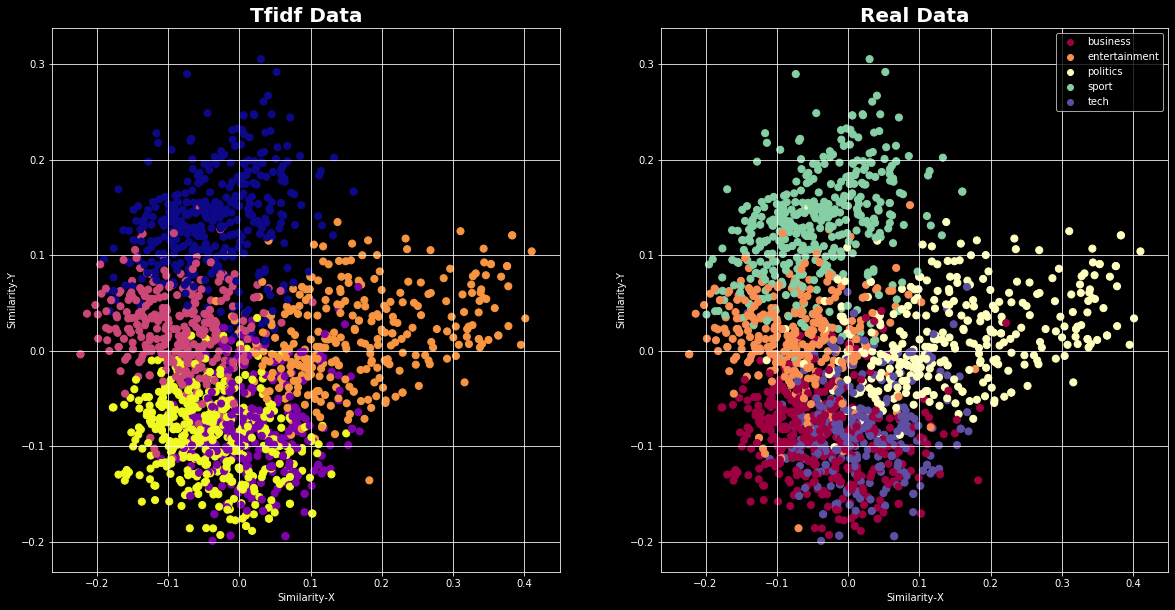

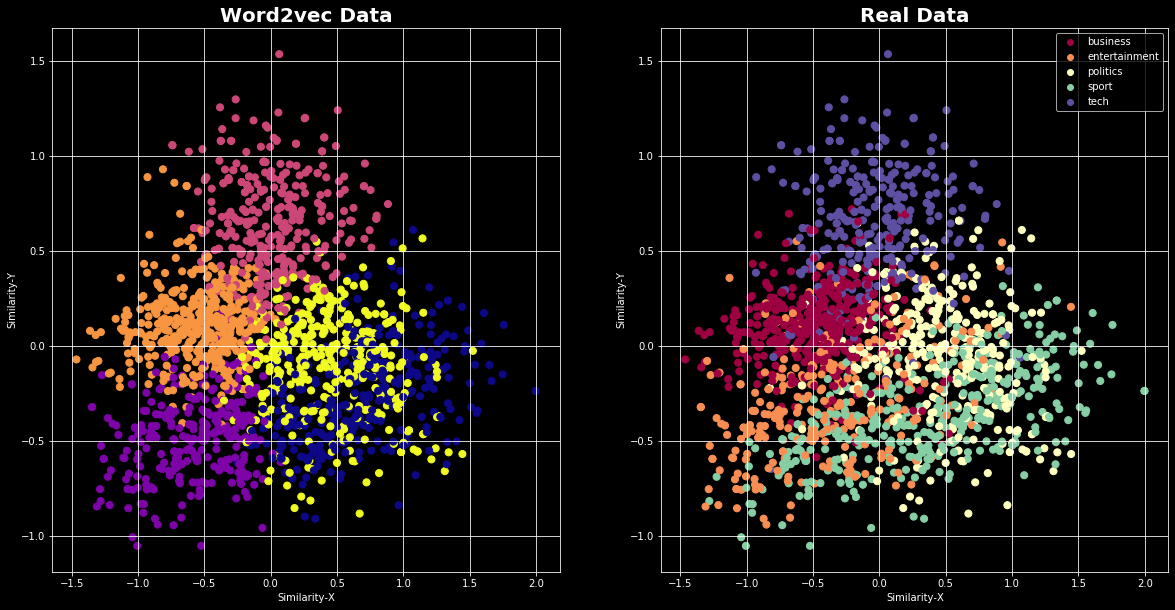

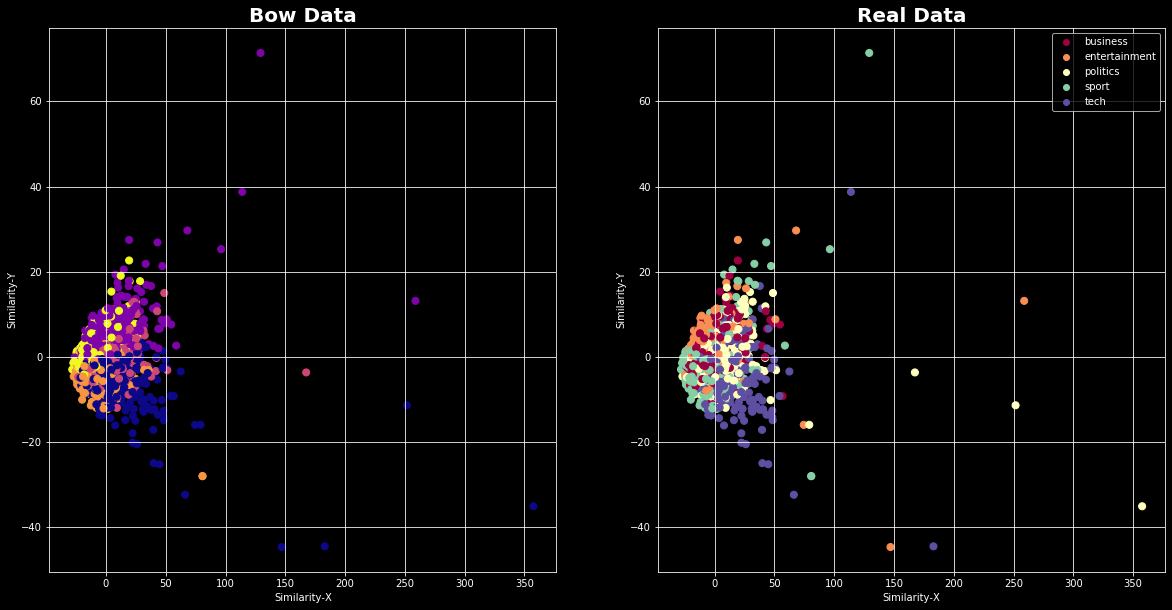

In [37]:
from sklearn.decomposition import PCA 

modelPlots(PCA(n_components=2),vectorizedSent,tfidf_train,count_train.todense(),y_train)

---
# Singular Value Decomposition (SVD)

>The Singular Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.
It is one of the most widely used Unsupervised learning algorithms, that is at the center of many recommendation and Dimensionality reduction systems that are the core of global companies.

__Advantages of SVD__:

* It’s very efficient (via Lanczos algorithm or similar it can be applied to really big matrices)
* The basis is hierarchical, ordered by relevance
* It tends to perform quite well for most data sets

__Disadvantages of SVD__:

* If the data is strongly non-linear it may not work so well
* Results are not always the best for visualization
* It is difficult to interpret
* Strongly focused in variance, sometimes there’s not a direct relationship between variance and predictive power so it can discard useful information

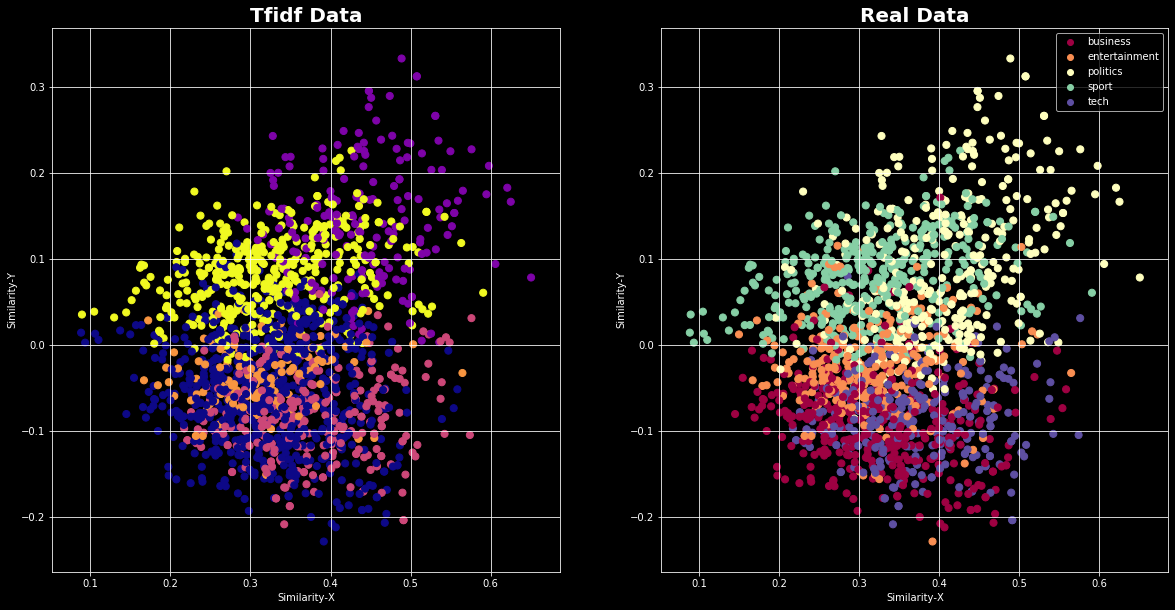

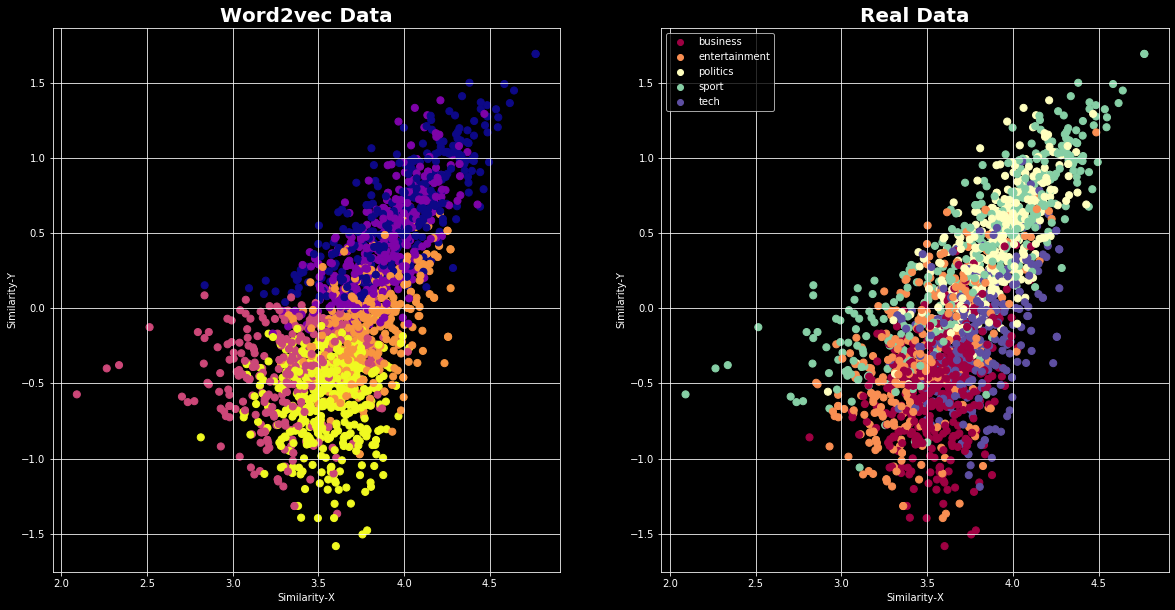

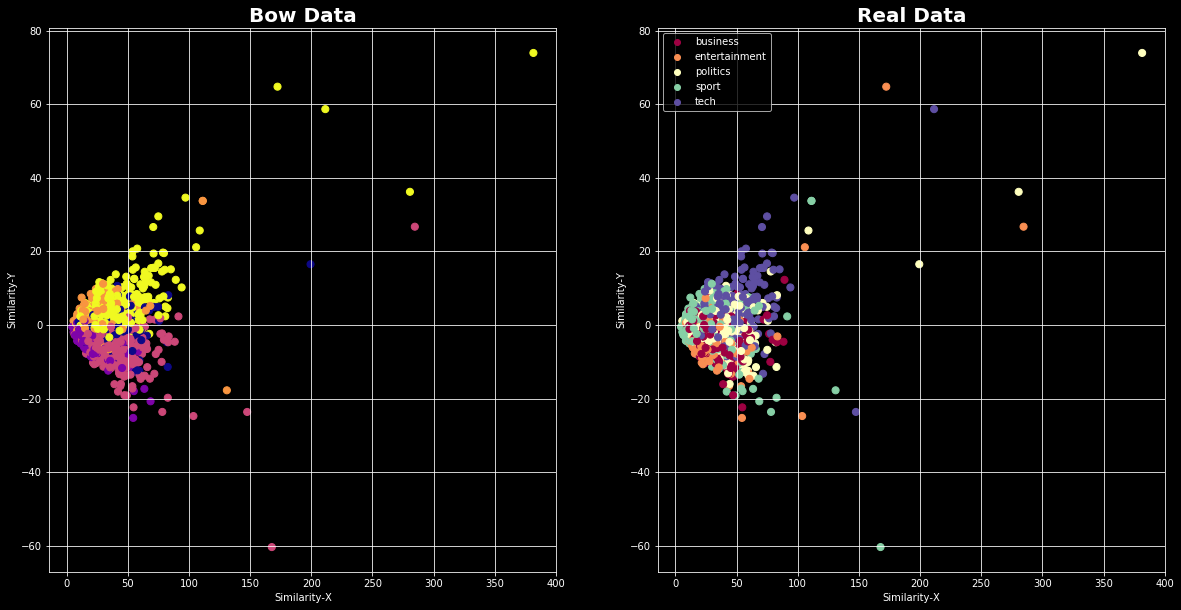

In [38]:
from sklearn.decomposition import TruncatedSVD

modelPlots(TruncatedSVD(n_components=2, random_state=None),vectorizedSent,tfidf_train,count_train.todense(),y_train) 

---
# Independent Component Analysis (ICA)

> Independent component analysis (ICA) defines a generative model for the observed multivariate data, which is typically given as a large database of samples. In the model, the data variables are assumed to be linear mixtures of some unknown latent variables, and the mixing system is also unknown. The latent variables are assumed nongaussian and mutually independent, and they are called the independent components of the observed data. These independent components, also called sources or factors, can be found by ICA.

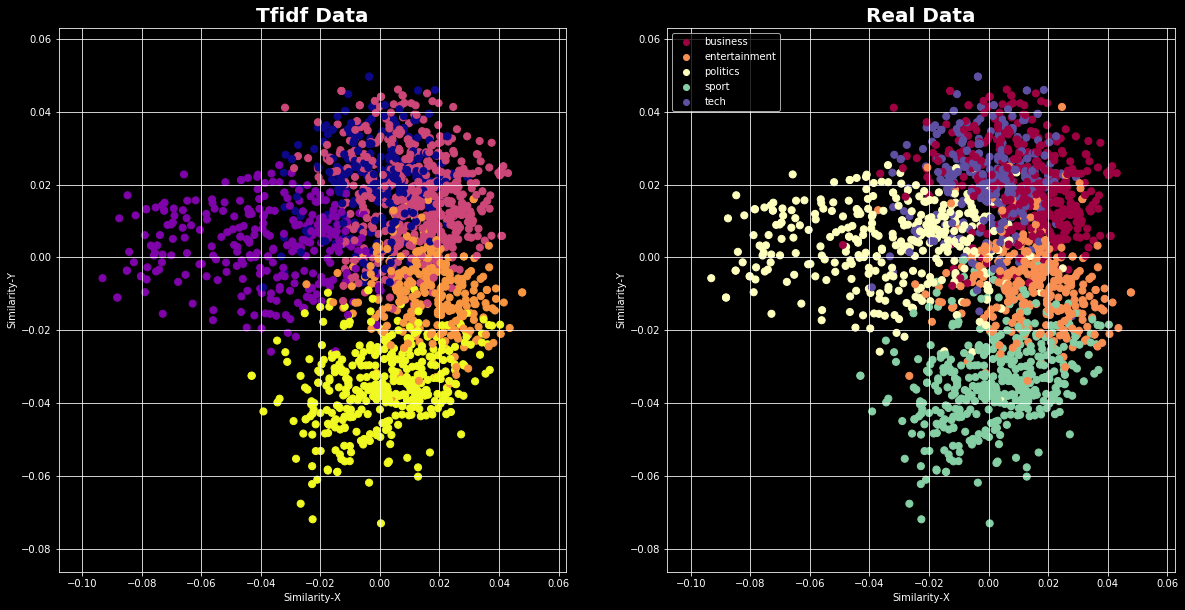

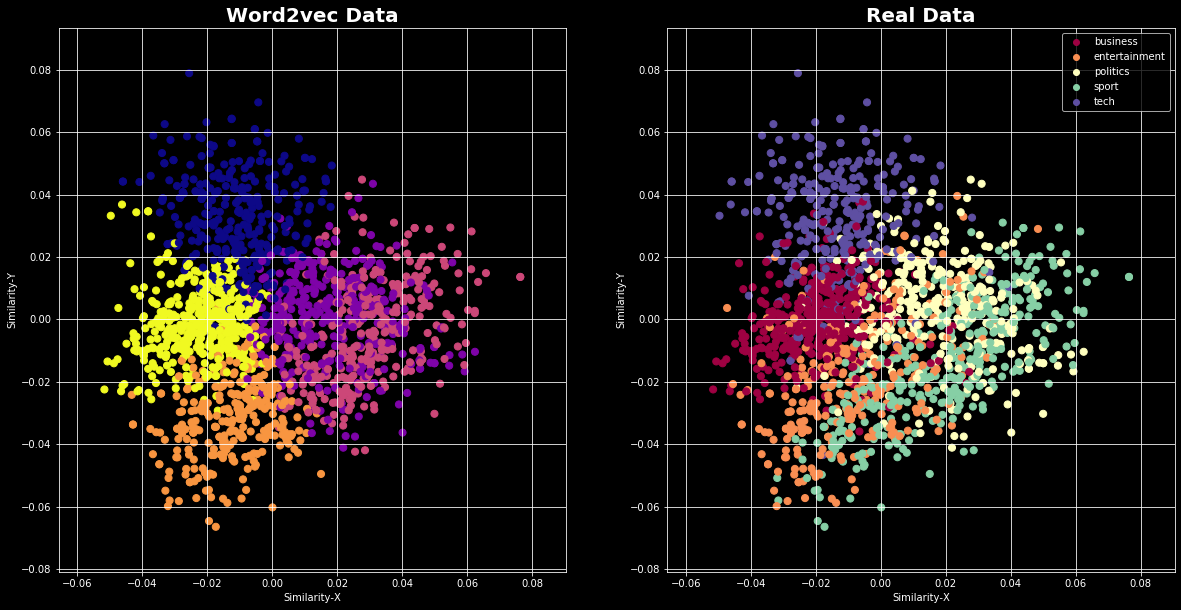

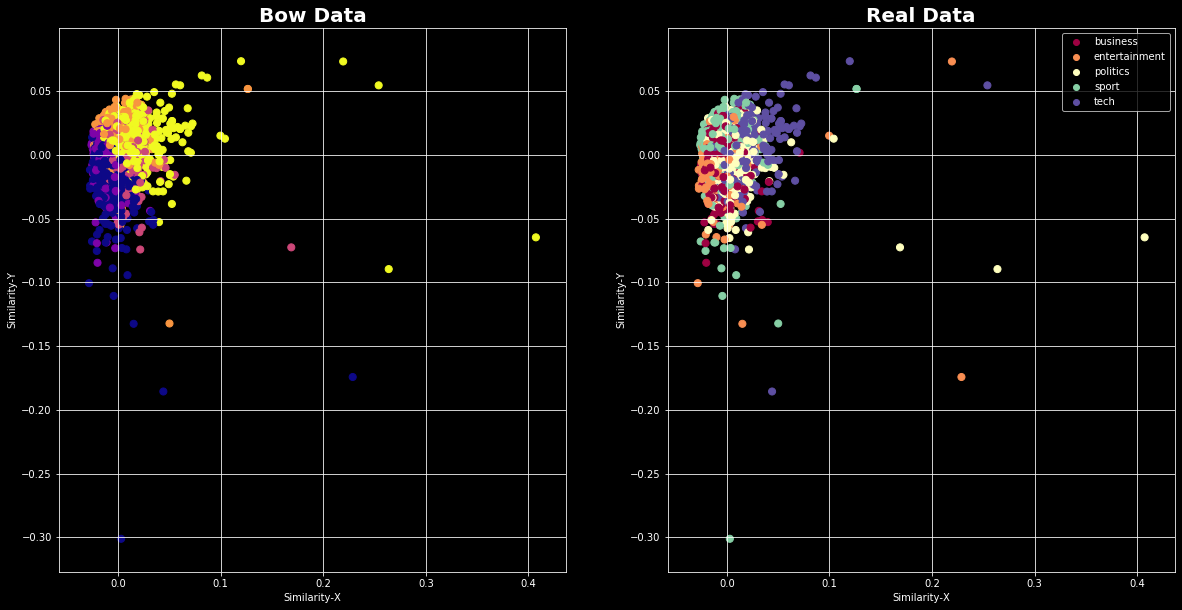

In [41]:
from sklearn.decomposition import FastICA

modelPlots(FastICA(n_components=2, random_state=0),vectorizedSent,tfidf_train,count_train.todense(),y_train)